# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

import requests
from PIL import Image
import shutil
import urllib
from io import BytesIO
import base64

import imageio
import pillow_avif

from os.path import exists

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from string import punctuation
punctuation = list(punctuation)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
lemmatizer = WordNetLemmatizer()
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from reportlab.lib.pagesizes import LETTER
from reportlab.lib.units import inch
from reportlab.pdfgen.canvas import Canvas
from reportlab.platypus import SimpleDocTemplate, ListFlowable, ListItem, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import Paragraph
from reportlab.platypus import Image as IMG
from reportlab.lib import colors

# Import Dataset

In [2]:
dataset_filename = "RawData.xlsx"

df_raw = pd.read_excel(dataset_filename);
print(df_raw.info());
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    77 non-null     object 
 1   Name                  77 non-null     object 
 2   Capsule Image         77 non-null     object 
 3   Sleeve Image          77 non-null     object 
 4   Type                  77 non-null     object 
 5   Status                77 non-null     object 
 6   Category              77 non-null     object 
 7   Cup Size              77 non-null     object 
 8   Headline              77 non-null     object 
 9   Intensity             58 non-null     float64
 10  Price                 77 non-null     float64
 11  Notes                 76 non-null     object 
 12  Taste                 77 non-null     object 
 13  Acidity               70 non-null     float64
 14  Bitterness            70 non-null     float64
 15  Roastiness            70 

,ID,Name,Capsule Image,Sleeve Image,Type,Status,Category,Cup Size,Headline,Intensity,...,Milky Taste,Bitterness with Milk,Roastiness with Milk,Creamy Texture,Description,Origin,Roasting,Contents & Allergens,Ingredients,Net Weight
0,OL1,Ispirazione Napoli,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/shared_res/agility/n...,Original,Current,Italian Espressos,25 ml (Ristretto) & 40 ml (Espresso),Dark & Creamy,13.0,...,NaN,NaN,NaN,NaN,"Ispirazione Napoli pays tribute to the short, ...",This intense blend is created mostly using Rob...,"A dark and intense roast, done with carefully ...",10 capsules of roast and ground coffee for the...,Roast and ground coffee,57 g - 2.01 oz for 10 capsules
1,OL2,Kazaar,https://www.nespresso.com/ecom/medias/sys_mast...,https://m.media-amazon.com/images/I/51vv3BK5ST...,Original,Current,Italian Espressos,25 ml (Ristretto) & 40 ml (Espresso),Exceptionally Intense & Syrupy,12.0,...,NaN,NaN,NaN,NaN,"A long, dark roast inspired by the union of Si...",NaN,NaN,10 capsules of roast and ground coffee for the...,Roast and ground coffee,60 g - 2.11 oz for 10 capsules
2,OL3,Ristretto,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/shared_res/agility/n...,Original,Current,Italian Espressos,25 ml (Ristretto) & 40 ml (Espresso),Powerful & Contrasting,10.0,...,NaN,NaN,NaN,NaN,"You can't help but fall for Ristretto, a canad...",This complex blend is created using Arabicas f...,The Robustas in Ristretto go through a long ro...,10 capsules of roast and ground coffee for the...,Roast and ground coffee,57 g - 2.01 oz for 10 capsules
3,OL4,Ristretto Decaffeinato,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/shared_res/agility/n...,Original,Current,Italian Espressos,25 ml (Ristretto) & 40 ml (Espresso),Powerful & Contrasting,10.0,...,NaN,NaN,NaN,NaN,It’s a profile worthy of an ambassador – a cof...,NaN,NaN,10 capsules of roast and ground coffee for the...,Decaffeinated roast and ground coffee.,57 g - 2.01 oz for 10 capsules
4,OL5,Arpeggio,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/shared_res/agility/n...,Original,Current,Italian Espressos,25 ml (Ristretto) & 40 ml (Espresso),Intense & Creamy,9.0,...,NaN,NaN,NaN,NaN,"A Nespresso classic, Arpeggio's coffees are sh...",This 100% Arabica blend is created using beans...,An intense roast of the coffee beans develops ...,10 capsules of roast and ground coffee for the...,Roast and ground coffee,53 g - 1.86 oz for 10 capsules


# Download Images (DEPRECATED)

In [3]:
def download_image(dataframe, index, folder):
    ID = dataframe.loc[index, "ID"];
    Name = dataframe.loc[index, "Name"];
    Type = dataframe.loc[index, "Type"];
    
    success = True;

    filename_capsule = f"{folder}/{ID}_{Name}_{Type}_Capsule.png";
    filename_sleeve = f"{folder}/{ID}_{Name}_{Type}_Sleeve.png";

    # Check if images already exist in the Images directory
    if (exists(filename_capsule) == True) & (exists(filename_sleeve) == True):
        print(f"{ID}: {Type} {Name} coffee images already exist in the Images directory.");
    
        dataframe.loc[index, "Capsule Image"] = filename_capsule;
        dataframe.loc[index, "Sleeve Image"] = filename_sleeve;
    else:
        # Attempt to download images using the URLs provided in raw dataset
        try:
            img_capsule = Image.open(requests.get(dataframe.loc[index, "Capsule Image"], stream=True).raw);
            img_sleeve = Image.open(requests.get(dataframe.loc[index, "Sleeve Image"], stream=True).raw);
        except:
            success = False;
        # Indicate which coffee's images cannot be automatically downloaded
        if success == False:
            print(f"{ID}: {Type} {Name} (i.e., index = {index}) coffee images could not be downloaded automatically.");
        # Save coffee images to Images directory and adjust the column values for Capsule Image and Sleeve Image to match with the newly downloaded images' local filepath
        else:
            img_capsule.save(filename_capsule, "PNG");
            img_sleeve.save(filename_sleeve, "PNG");

            dataframe.loc[index, "Capsule Image"] = filename_capsule;
            dataframe.loc[index, "Sleeve Image"] = filename_sleeve;

            print(f"{ID}: {Type} {Name} coffee images downloaded & saved.");

# Convert Raw Images

In [4]:
def convert_image(dataframe, index, input_folder, output_folder, imageType):
    ID = dataframe.loc[index, "ID"];
    Name = dataframe.loc[index, "Name"];
    Type = dataframe.loc[index, "Type"];
    
    baseFilePath = f"{ID}_{Name}_{Type}_{imageType}";

    rawImage = input_folder+"/"+baseFilePath;
    convertedImage = output_folder+"/"+baseFilePath;
    
    if(exists(output_folder+"/"+baseFilePath+".png") == True):
        print(f"{ID}: {Type} {Name} {imageType} image already exists in the Images directory.");

        dataframe.loc[index, f"{imageType} Image"] = convertedImage+".png";

    else:

        if(exists(rawImage+".webp") == True):
            
            webp_image = Image.open(rawImage+".webp");
            webp_image.save(convertedImage+".png", "PNG");

            dataframe.loc[index, f"{imageType} Image"] = convertedImage+".png";
            
            print(f"{ID}: {Type} {Name} {imageType} RAW image converted from webp to png, and saved in Images directory.");
        
        elif(exists(rawImage+".avif") == True):
            
            # avif_image = imageio.imread(rawImage+".avif");
            # imageio.imwrite(convertedImage+".png", avif_image, format="PNG");

            webp_image = Image.open(rawImage+".avif");
            webp_image.save(convertedImage+".png", "PNG");

            dataframe.loc[index, f"{imageType} Image"] = convertedImage+".png";
            
            print(f"{ID}: {Type} {Name} {imageType} RAW image converted from avif to png, and saved in Images directory.");
        
        elif(exists(rawImage+".jpg") == True):

            im = Image.open(rawImage+".jpg");
            im.save(convertedImage+".png", "PNG");
        
            dataframe.loc[index, f"{imageType} Image"] = convertedImage+".png";
            
            print(f"{ID}: {Type} {Name} {imageType} RAW image converted from jpg to png, and saved in Images directory.");
        
        elif(exists(rawImage+".png") == True):
            
            shutil.copy(rawImage+".png", "Images");
            
            dataframe.loc[index, f"{imageType} Image"] = convertedImage+".png";
            
            print(f"{ID}: {Type} {Name} {imageType} RAW image already in png format; copied to Images directory.");

        else:
            print(f"{ID}: {Type} {Name} {imageType} RAW image does not exist in the RawImages directory.");

# Create Charts

In [5]:
def createTasteChart(dataframe, index, folder):
    ID = dataframe.loc[index, "ID"];
    Name = dataframe.loc[index, "Name"];
    Type = dataframe.loc[index, "Type"];

    title = f"{Type} - {Name}: Taste Profile";
    filename_chart = f"{folder}/{ID}_{Name}_{Type}_Taste Profile.png";

    if (exists(filename_chart) == True):
        print(f"{ID}: {Type} {Name} taste profile chart already exists in the Charts directory.");
    elif Name in ["Cold Brew Style Intense","Ice Forte","Ice Leggero"]:
        print(filename_chart + " Not Applicable without sufficient data");
    else: 
        if Name in ["Corto","Scuro","Chiaro","Bianco Forte"]:
            col_list = ["Milky Taste","Bitterness with Milk","Roastiness with Milk","Creamy Texture"];
        else:
            col_list = ["Acidity","Bitterness","Roastiness","Body"];
        
        data = [];
        for col in col_list:
            data.append([col, dataframe.loc[index, col]]);
        df_agg = pd.DataFrame(data, columns=["Profile","Measure"]);

        fig, ax = plt.subplots(figsize=(8,4));
        ax = sns.barplot(data=df_agg, x="Profile", y="Measure");
        ax.set(title=title);
        ax.set_ylim(0,5);

        plt.savefig(filename_chart);

        print(f"{ID}: {Type} {Name} taste profile chart saved to Charts directory.");
    
    dataframe.loc[index, "Taste Profile Chart"] = filename_chart;

# Machine Learning

In [6]:
def dataAggregationNormalization(dataframe):
    dff = dataframe.copy();

    # Create Unique Names for some flavours that share the same name ----------
    dff["Unique Name"] = dff["Name"];
    for i in dff.index:
        if dff.loc[i, "Name"] in ["Peru Organic","Ethiopia"]:
            dff.loc[i, "Unique Name"] = f"{dff.loc[i, 'Name']} ({dff.loc[i, 'Type']})";
    
    # Estimate Intensity for Coffee that do not have an prescribed level -----
    dff["Estimated Intensity"] = dff["Intensity"];
    nullIntensityRowIDs = dff[dff["Intensity"].isnull()].index.to_list();
    for id in nullIntensityRowIDs:
        if dff.loc[id, "Name"] == "Corto":
            dff.loc[id, "Estimated Intensity"] = 11;
        
        elif dff.loc[id, "Name"] == "Scuro":
            dff.loc[id, "Estimated Intensity"] = 8;
        
        elif dff.loc[id, "Name"] in ["Carafe Pour-Over Style","Bianco Piccolo","Bianco Forte"]:
            dff.loc[id, "Estimated Intensity"] = 7;
        
        elif dff.loc[id, "Name"] in ["Cioccolatino","Vaniglia","Nocciola","Caramello","Chiaro","Bianco Doppio"]:
            dff.loc[id, "Estimated Intensity"] = 6;
        
        elif dff.loc[id, "Name"] in ["Cold Brew Style Intense","Carafe Pour-Over Style Mild","Golden Caramel","Sweet Vanilla","Rich Chocolate","Roasted Hazelnut","Ice Forte","Ice Leggero"]:
            dff.loc[id, "Estimated Intensity"] = 5;
    
    # Determine Intensity Classification based on Estimated Intensity -------
    dff["Intensity Classification"] = "";
    for i in dff.index:
        intensity = dff.loc[i, "Estimated Intensity"];
        if intensity > 0 and intensity < 5:
            dff.loc[i,"Intensity Classification"] = "Blonde";
        elif intensity >= 5 and intensity <= 7:
            dff.loc[i,"Intensity Classification"] = "Medium";
        else:
            dff.loc[i,"Intensity Classification"] = "Dark";

    # Estimate Taste Profile Classification ----------------------------------
    for col in ['Acidity','Bitterness','Roastiness','Body','Milky Taste','Bitterness with Milk','Roastiness with Milk','Creamy Texture']:
        dff[f"{col} Classification"] = "";
        for i in dff.index:
            tasteProfileLevel = dff.loc[i, col];
            if tasteProfileLevel <= 2:
                dff.loc[i, f"{col} Classification"] = "Low";
            elif tasteProfileLevel > 2 and tasteProfileLevel < 4:
                dff.loc[i, f"{col} Classification"] = "Medium";
            elif tasteProfileLevel >= 4:
                dff.loc[i, f"{col} Classification"] = "High";
            # else:
            #     dff.loc[i, f"{col} Classification"] = "Medium";
    
    # Filter and show dataframe with newly created columns & values ----------
    col_list = [
        # Identification Columns
        "ID","Name","Type",
        # Aggregation/Normalization Columns
        "Unique Name","Estimated Intensity","Intensity Classification"
    ]
    # Aggregation/Normalization Columns (cont.)
    for col in ['Acidity','Bitterness','Roastiness','Body','Milky Taste','Bitterness with Milk','Roastiness with Milk','Creamy Texture']:
        col_list.append(f"{col} Classification");

    return dff[col_list];

|POS Tag|Grammatical Classification|
|--|--| 
|PNP|Personal pronoun (e.g. I, you, them, ours)| 
|PNQ|Wh-pronoun (e.g. who, whenever, whom)| 
|PNX|Reflexive pronoun (e.g. who, whoever, whom)| 
|POS|The possessive or genitive marker 's or'| 
|AVQ|Wh-adverb (e.g. when, where, how, why, wherever)| 
|CJC|Coordinating conjunction (e.g. up, off, out)| 
|CJS|Subordinating conjunction (e.g. although, when)| 
|CJT|The subordinating conjunction that| 
|DTQ|Wh-determiner-pronoun (e.g. which, what, whose, whichever)| 
|ITJ|Interjection or other isolate (e.g. oh, yes, mhm, wow)| 
|PRF|The preposition of| 
|PRP|Preposition (except for of) (e.g. about, an, in, on, on behalf of, with)|

In [7]:
def process_text_for_NLP(dataframe, index, columns_NLP):
    ID = dataframe.loc[index, "ID"];
    Name = dataframe.loc[index, "Name"];
    Type = dataframe.loc[index, "Type"];
    textualInfo = "";
    for col in columns_NLP:
        if pd.isna(dataframe.loc[index, col]) == False:
            textualInfo += str(dataframe.loc[index, col]).lower() + " ";
    textualInfo = textualInfo[:-1];
    textualInfo_tokens = word_tokenize(textualInfo);
    textualInfo_cleanedTokens = [];
    for token in textualInfo_tokens:
        token = lemmatizer.lemmatize(token, pos="a");
        # if (token not in stop_words) and (token not in punctuation):
        if (token not in stop_words) and (token not in punctuation) and (token.isnumeric() == False):
            token = re.sub(r'[^\w\s]', '', token);
            if token != '':
                if str(nlp(token)[0].pos_) not in ["PNP","PNQ","PNX","POS","AVQ","CJC","CJS","CJT","DTQ","ITJ","PRF","PRP"]:
                    textualInfo_cleanedTokens.append(token);
    textualInfo_final = "";
    for token in textualInfo_cleanedTokens:
        textualInfo_final += token + " ";
    textualInfo_final = textualInfo_final[:-1];
    dataframe.loc[index, "Textual Info"] = textualInfo_final;
    print(f"{ID}: {Type} {Name} NLP pre-processing completed.");

In [8]:
# This function creates a word cloud showing the words that best describe the coffee in terms of significance and frequency
def get_wordcloud(dataframe, coffee_select, image):
    try:
        wordcloud = WordCloud(
            background_color="black", 
            max_words=5000, 
            contour_width=3, 
            contour_color="steelblue", 
            mask=image,
            colormap='Accent_r'
        );
    except:
        wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=3, contour_color="steelblue", colormap='Accent_r');
    
    mask = dataframe["Unique Name"] == coffee_select;
    
    idx = dataframe.index[mask].tolist()[0];
    wc = wordcloud.generate(dataframe.loc[idx, "Textual Info"]);
    # return wc.to_image();
    return wc;

In [9]:
# This function takes the selected coffee and shuffles it to the top of a newly created duplicate dataframe
def get_dataframeNLP(dataframe, coffee_select):
    df_coffeeSelect = dataframe[dataframe["Unique Name"] == coffee_select];

    df_NLP = pd.concat([df_coffeeSelect, dataframe]);
    df_NLP = df_NLP.drop_duplicates();
    df_NLP = df_NLP[df_NLP.columns.tolist()[1:]];
    df_NLP = df_NLP.reset_index();
    return df_NLP;

# This function outputs recommendations based on the selected coffee along with brief information and similarity score
def get_recommendations(df_NLP, coffee_select, numRec, indices, sim_measure):
    idx = indices[coffee_select];
    
    sim_scores = list(enumerate(sim_measure[idx]));
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True);
    
    sim_scores = sim_scores[1:numRec+1];
    coffee_indices = [i[0] for i in sim_scores];
    
    df_Rec = df_NLP[["Unique Name","Type","Headline","Cup Size","Intensity"]].iloc[coffee_indices];
    
    similarityScores = [];
    for i in range(len(sim_scores)):
        similarityScores.append(round(sim_scores[i][1], 4));
    df_Rec["Similarity Score"] =  similarityScores;
    
    df_Rec = df_Rec.reset_index().rename(columns={"index":"id"});

    df_Rec = df_Rec[df_Rec.columns[1:]];
    
    return df_Rec;

# Retrieve recommendations based on selected coffee using pre-specified vectorization method
def get_recommendationResults(dataframe, coffee_select, numRec, vectorizer, similarity):
    df_NLP = get_dataframeNLP(dataframe, coffee_select);

    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    sim_measure = similarity(matrix, matrix);

    indices = pd.Series(df_NLP.index, index=df_NLP["Unique Name"]).drop_duplicates();
    
    df_Rec = get_recommendations(dataframe, coffee_select, numRec, indices, sim_measure);
    if (similarity.__name__ != 'cosine_similarity') & (similarity.__name__ != 'linear_kernel'):
        df_Rec = df_Rec.sort_values(by='Similarity Score', ascending=True).reset_index(drop=True);
    
    return df_Rec;

# Retrieve most important features of selected coffee based on pre-specified vectorization method 
def get_featureResults(dataframe, coffee_select, vectorizer, col_name):
    df_NLP = get_dataframeNLP(dataframe, coffee_select);
    
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    df_Feature = pd.DataFrame(matrix[0].T.todense(), 
        index=vectorizer.get_feature_names_out(), 
        columns=[col_name]
    );
    df_Feature = df_Feature.sort_values(col_name, ascending=False);
    df_Feature = df_Feature[df_Feature[col_name] > 0];
    return df_Feature;

In [10]:
def createWordCloud(dataframe, index, folder, image):
    ID = dataframe.loc[index, "ID"];
    Name = dataframe.loc[index, "Name"];
    Type = dataframe.loc[index, "Type"];
    UniqueName = dataframe.loc[index, "Unique Name"];

    filename_wordcloud = f"{folder}/{ID}_{Name}_{Type}_Word Cloud.png";
    title = f"{Type} - {Name}: Word Cloud";
    
    if (exists(filename_wordcloud) == True):
        print(f"{ID}: {Type} {Name} word cloud already exists in the Charts directory.");
    else:
        wc = get_wordcloud(dataframe, UniqueName, image);

        plt.figure(figsize=(8, 6));
        plt.imshow(wc, interpolation='bilinear');
        plt.title(title);
        plt.axis("off");
        plt.savefig(filename_wordcloud, bbox_inches='tight', pad_inches=0.2, dpi=300);
        print(f"{ID}: {Type} {Name} word cloud saved to Charts directory.");
    
    dataframe.loc[index, "Word Cloud"] = filename_wordcloud;

In [11]:
# Create recommendations table and export as image (DEPRECATED)
# => Formatting of table image is not optimal for report
def createRecommendationsTable(dataframe, index, folder, numRec, vectorizer, similarity):
    ID = dataframe.loc[index, "ID"];
    Name = dataframe.loc[index, "Name"];
    Type = dataframe.loc[index, "Type"];
    UniqueName = dataframe.loc[index, "Unique Name"];

    filename_recTable = f"{folder}/{ID}_{Name}_{Type}_Recommendations Table.png";

    if (exists(filename_recTable) == True):
        print(f"{ID}: {Type} {Name} recommendations table already exists in the Charts directory.");
    else:
        df_rec = get_recommendationResults(dataframe, UniqueName, numRec, vectorizer, similarity);

        fig, ax = plt.subplots(figsize=(10,1));
        table = ax.table(cellText=df_rec.values, colLabels=df_rec.columns, loc='center');
        ax.axis('off');
        plt.savefig(filename_recTable, dpi=300);
        print(f"{ID}: {Type} {Name} recommendations table saved to Charts directory.");

    dataframe.loc[index, "Recommendations Table"] = filename_recTable;

# Create recommendations table and export as dataframe
def createRecommendationsTable(dataframe, index, numRec, vectorizer, similarity, dataframe_list):
    ID = dataframe.loc[index, "ID"];
    Name = dataframe.loc[index, "Name"];
    Type = dataframe.loc[index, "Type"];
    UniqueName = dataframe.loc[index, "Unique Name"];

    df_rec = get_recommendationResults(dataframe, UniqueName, numRec, vectorizer, similarity);
    dataframe_list.append(
        {
            "name":UniqueName,
            "recommendations":df_rec
        }
    );
    print(f"{ID}: {Type} {Name} recommendation results generated and saved.");

In [12]:
def createFeaturesChart(dataframe, index, folder, vectorizer, col_name):
    ID = dataframe.loc[index, "ID"];
    Name = dataframe.loc[index, "Name"];
    Type = dataframe.loc[index, "Type"];
    UniqueName = dataframe.loc[index, "Unique Name"];

    filename_features = f"{folder}/{ID}_{Name}_{Type} Feature Results.png";
    title = f"{Type} - {Name}: Feature Results";

    if (exists(filename_features) == True):
        print(f"{ID}: {Type} {Name} feature results already exists in the Charts directory.");
    else:
        df_features = get_featureResults(dataframe, UniqueName, vectorizer, col_name);

        fig, ax = plt.subplots(figsize=(8,4));
        sns.barplot(data=df_features, x=col_name, y=df_features.index);
        ax.set(title=title);
        plt.savefig(filename_features);
        print(f"{ID}: {Type} {Name} feature results saved to Charts directory.");

    dataframe.loc[index, "Feature Results"] = filename_features;

# Proceduraly Generate Image Conversions & Charts, and perform Machine Learning

In [13]:
df_agg = dataAggregationNormalization(df_raw);
df_agg = df_agg[df_agg.columns[3:]];

df = pd.concat([df_raw.copy(), df_agg], axis=1);

print(df.columns);

Index(['ID', 'Name', 'Capsule Image', 'Sleeve Image', 'Type', 'Status',
       'Category', 'Cup Size', 'Headline', 'Intensity', 'Price', 'Notes',
       'Taste', 'Acidity', 'Bitterness', 'Roastiness', 'Body', 'Milky Taste',
       'Bitterness with Milk', 'Roastiness with Milk', 'Creamy Texture',
       'Description', 'Origin', 'Roasting', 'Contents & Allergens',
       'Ingredients', 'Net Weight', 'Unique Name', 'Estimated Intensity',
       'Intensity Classification', 'Acidity Classification',
       'Bitterness Classification', 'Roastiness Classification',
       'Body Classification', 'Milky Taste Classification',
       'Bitterness with Milk Classification',
       'Roastiness with Milk Classification', 'Creamy Texture Classification'],
      dtype='object')


In [14]:
columns_NLP = df.columns[4:].to_list();
df["Taste Profile Chart"] = "";
df["Textual Info"] = "";
for i in df.index:
    # download_image(df, i, "Images");
    convert_image(df, i, "RawImages", "Images", "Capsule");
    convert_image(df, i, "RawImages", "Images", "Sleeve");
    createTasteChart(df, i, "Charts");
    process_text_for_NLP(df, i, columns_NLP);

OL1: Original Ispirazione Napoli Capsule image already exists in the Images directory.
OL1: Original Ispirazione Napoli Sleeve image already exists in the Images directory.
OL1: Original Ispirazione Napoli taste profile chart already exists in the Charts directory.


OL1: Original Ispirazione Napoli NLP pre-processing completed.
OL2: Original Kazaar Capsule image already exists in the Images directory.
OL2: Original Kazaar Sleeve image already exists in the Images directory.
OL2: Original Kazaar taste profile chart already exists in the Charts directory.
OL2: Original Kazaar NLP pre-processing completed.
OL3: Original Ristretto Capsule image already exists in the Images directory.
OL3: Original Ristretto Sleeve image already exists in the Images directory.
OL3: Original Ristretto taste profile chart already exists in the Charts directory.
OL3: Original Ristretto NLP pre-processing completed.
OL4: Original Ristretto Decaffeinato Capsule image already exists in the Images directory.
OL4: Original Ristretto Decaffeinato Sleeve image already exists in the Images directory.
OL4: Original Ristretto Decaffeinato taste profile chart already exists in the Charts directory.
OL4: Original Ristretto Decaffeinato NLP pre-processing completed.
OL5: Original Arpe

OL1: Original Ispirazione Napoli word cloud already exists in the Charts directory.


OL1: Original Ispirazione Napoli recommendation results generated and saved.
OL1: Original Ispirazione Napoli feature results already exists in the Charts directory.
OL2: Original Kazaar word cloud already exists in the Charts directory.
OL2: Original Kazaar recommendation results generated and saved.
OL2: Original Kazaar feature results already exists in the Charts directory.
OL3: Original Ristretto word cloud already exists in the Charts directory.
OL3: Original Ristretto recommendation results generated and saved.
OL3: Original Ristretto feature results already exists in the Charts directory.
OL4: Original Ristretto Decaffeinato word cloud already exists in the Charts directory.
OL4: Original Ristretto Decaffeinato recommendation results generated and saved.
OL4: Original Ristretto Decaffeinato feature results already exists in the Charts directory.
OL5: Original Arpeggio word cloud already exists in the Charts directory.
OL5: Original Arpeggio recommendation results generated and s

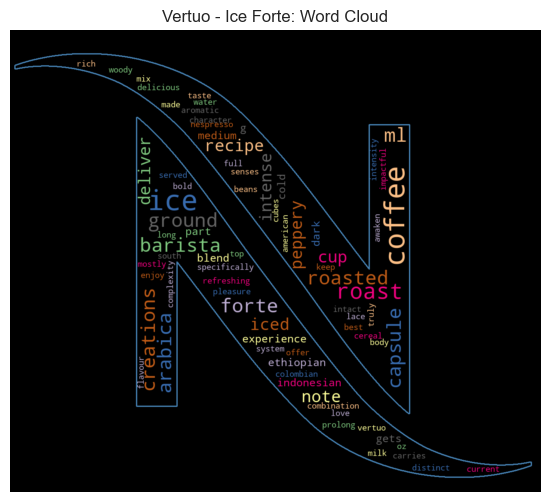

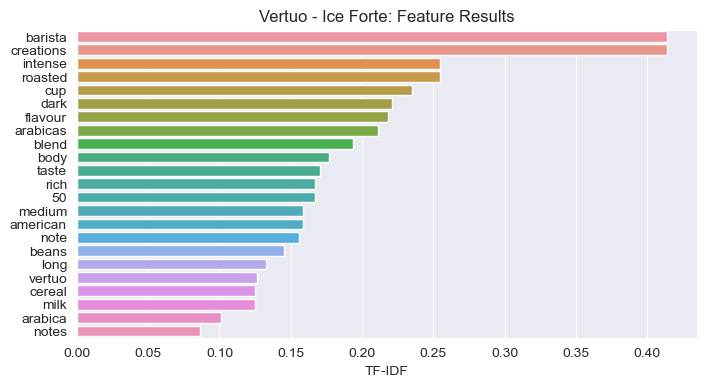

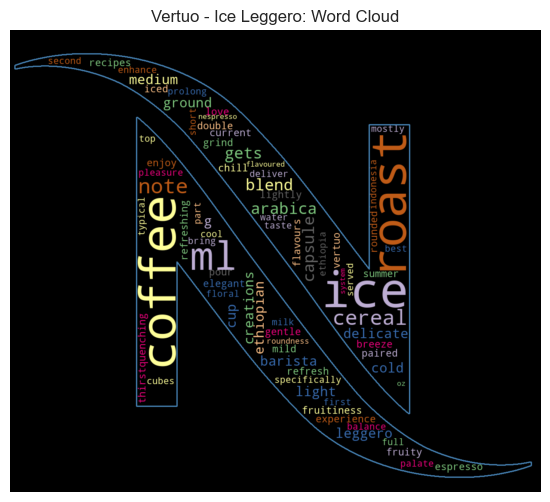

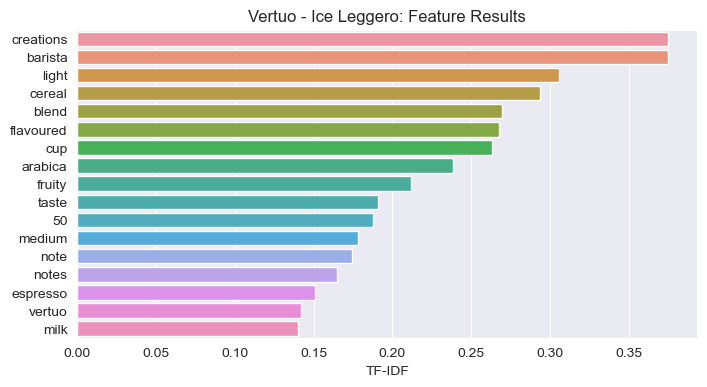

In [15]:
image = np.array(Image.open('logo_v2.png'));
df["Word Cloud"] = "";

numRec=5;
vectorizer=TfidfVectorizer(min_df=2, max_df=0.95, max_features=50, stop_words="english", sublinear_tf=True, ngram_range=(1,1));
similarity=linear_kernel;
col_name = "TF-IDF";

# df["Recommendations Table"] = "";
recommendationTables = [];

df["Feature Results"] = "";

for i in df.index:
    createWordCloud(df, i, "Charts", image);
    # createRecommendationsTable(df, i, "Charts", numRec, vectorizer, similarity)
    createRecommendationsTable(df, i, numRec, vectorizer, similarity, recommendationTables);
    createFeaturesChart(df, i, "Charts", vectorizer, col_name);

In [16]:
print(df.columns);

Index(['ID', 'Name', 'Capsule Image', 'Sleeve Image', 'Type', 'Status',
       'Category', 'Cup Size', 'Headline', 'Intensity', 'Price', 'Notes',
       'Taste', 'Acidity', 'Bitterness', 'Roastiness', 'Body', 'Milky Taste',
       'Bitterness with Milk', 'Roastiness with Milk', 'Creamy Texture',
       'Description', 'Origin', 'Roasting', 'Contents & Allergens',
       'Ingredients', 'Net Weight', 'Unique Name', 'Estimated Intensity',
       'Intensity Classification', 'Acidity Classification',
       'Bitterness Classification', 'Roastiness Classification',
       'Body Classification', 'Milky Taste Classification',
       'Bitterness with Milk Classification',
       'Roastiness with Milk Classification', 'Creamy Texture Classification',
       'Taste Profile Chart', 'Textual Info', 'Word Cloud', 'Feature Results'],
      dtype='object')


# Create Report

In [17]:
def add_image_to_report(image_path, width, height):
    img = IMG(image_path);
    img.drawWidth = width
    img.drawHeight = height
    return img;

In [18]:
def validateEmptyColumnValues(dataframe, index, col_list):
    null_count = 0;
    for col in col_list:
        if pd.isna(dataframe.loc[index, col]) == True:
            null_count += 1;
    if null_count == len(col_list):
        return False;
    else:
        return True;

In [19]:
def dataframeTo2DList(dataframe, index, tables):
    table = [];
    if dataframe.loc[index, "Unique Name"] == tables[index].get("name"):
        table.append(tables[index].get("recommendations").columns.tolist());
        for i in range(len(recommendationTables[index].get("recommendations").values.tolist())):
            table.append(recommendationTables[index].get("recommendations").values.tolist()[i]);
        print(f"Dataframe for {dataframe.loc[index, 'Unique Name']} recommendation results converted to 2D List.")
        return table;
    else:
        print(f"Unable to create 2D List from {dataframe.loc[index, 'Unique Name']} recommendation results dataframe.")

In [26]:
def buildReport(dataframe, index, tables):
    # Instantiate Report and calibrate formatting ***************************
    my_doc = SimpleDocTemplate(
        "Guides/" + dataframe.loc[index, "ID"] + "_" + dataframe.loc[index, "Name"] + "_" + dataframe.loc[index, "Status"] + ".pdf",
        pagesize=LETTER
    );

    sample_style_sheet = getSampleStyleSheet();
    sample_style_sheet.list();
    
    sample_style_sheet.add(ParagraphStyle(
        name='CustomParagraph', 
        parent=sample_style_sheet['BodyText'],
        spaceBefore=5,
        spaceAfter=10,
    ))

    sample_style_sheet.add(ParagraphStyle(
        name='CustomParagraph1', 
        alignment=1,
        spaceBefore=5,
        spaceAfter=5
    ))

    sample_style_sheet.add(ParagraphStyle(
        name='CustomHeading', 
        parent=sample_style_sheet['Heading1'],
        spaceBefore=10,
        spaceAfter=10,
    ))

    sample_style_sheet.add(ParagraphStyle(
        name='CustomHeading1', 
        parent=sample_style_sheet['Heading1'],
        spaceBefore=10
    ))

    tableStyle = [
        ('BACKGROUND', (0, 0), (-1, 0), colors.gray),  # Header background color
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.white),  # Header text color
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),  # Cell alignment
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),  # Header font,
        ('BOTTOMPADDING', (0, 0), (-1, 0), 2),  # Header bottom padding
        ('BACKGROUND', (0, 1), (-1, -1), colors.lightgrey),  # Data background color
        ('GRID', (0, 0), (-1, -1), 1, colors.black),  # Gridlines,
    ];
    table_style = TableStyle(tableStyle);

    flowables = [];

    # Create Report Information *****************************************

    # Report Title (Capsule Image, Type, Name) -----------------------------

    # Capsule Image:
    img_capsule = add_image_to_report(dataframe.loc[i, "Capsule Image"], 100, 100);
    flowables.append(img_capsule);
    
    reportTitle = f"{dataframe.loc[index, 'Type']} - {dataframe.loc[index, 'Name']}";
    flowables.append(Paragraph(reportTitle, sample_style_sheet['Title']));

    # General Information (Status, Category, Cup Size, Headline, Intensity, Price, Notes) -----
    flowables.append(Paragraph("General Information", sample_style_sheet['Heading1']));

    genInfoList = [];
    for col in ["Status","Category","Cup Size","Headline", "Intensity","Price","Notes"]:
        if (isinstance(dataframe.loc[index, col], int) == True) | (isinstance(dataframe.loc[index, col], float) == True):
            genInfoList.append(f"<strong>{col}:</strong> " + str(dataframe.loc[index, col]));
        else:
            genInfoList.append(f"<strong>{col}:</strong> {dataframe.loc[index, col]}");
    for info in genInfoList:
        flowables.append(Paragraph(info, bulletText="-"));

    # Additional Information Table:
    addInfoData = [
        ["Fact","Detail"]
    ];
    for col in ["Contents & Allergens","Ingredients","Net Weight"]:
        addInfoData.append([col, dataframe.loc[index, col]]);
    addInfoTable = Table(addInfoData, spaceBefore=10);
    addInfoTable.setStyle(table_style);
    flowables.append(addInfoTable);

    # Taste Information (Taste, Notes, Acidity, Bitterness, Roastiness, Body) ---------
    if (validateEmptyColumnValues(dataframe, index, ["Acidity","Bitterness","Roastiness","Body","Milky Taste","Bitterness with Milk","Roastiness with Milk","Creamy Texture"]) == True):

        flowables.append(Paragraph("Taste Information", sample_style_sheet['CustomHeading']));

        flowables.append(Paragraph(dataframe.loc[index, "Taste"], sample_style_sheet['CustomParagraph']));

        img_tasteProfile = add_image_to_report(dataframe.loc[i, "Taste Profile Chart"], 450, 200);
        flowables.append(img_tasteProfile);

    # The Story (Sleeve Image, Description, Origin, Roasting) ----------------
    if (validateEmptyColumnValues(dataframe, index, ["Description","Origin","Roasting"]) == True):
    
        flowables.append(Paragraph("The Story", sample_style_sheet['CustomHeading1']));

        # Sleeve Image:
        img_sleeve = add_image_to_report(dataframe.loc[i, "Sleeve Image"], 200, 100);
        flowables.append(img_sleeve);

        for col in ["Description","Origin","Roasting"]:
            if isinstance(dataframe.loc[index, col], str) and (dataframe.loc[index, col] != ""):
                flowables.append(Paragraph(dataframe.loc[index, col], sample_style_sheet['CustomParagraph']));

    # Analysis (Word Cloud, Recommendations Table, Feature Results) --------------------------------
    flowables.append(Paragraph("Analysis", sample_style_sheet['Heading1']));

    # Recommendations Table:
    recData = dataframeTo2DList(dataframe, index, tables);

    recTable = Table(recData, spaceBefore=10, spaceAfter=10);
    tableStyle.append(
        ('FONTSIZE', (0, 0), (-1, -1), 8),  # Set font size for all cells
    );
    table_style = TableStyle(tableStyle);
    recTable.setStyle(table_style);

    flowables.append(Paragraph("<strong>Top Recommendations</strong>", sample_style_sheet["CustomParagraph1"]));
    flowables.append(recTable);

    flowables.append(Paragraph("<strong>High Frequency Words & Most Important Features</strong>", sample_style_sheet["CustomParagraph1"]));
    # Word Cloud:
    img_wordCloud = add_image_to_report(dataframe.loc[i, "Word Cloud"], 400, 350);
    flowables.append(img_wordCloud);

    # Feature Results:
    img_featureResults = add_image_to_report(dataframe.loc[i, "Feature Results"], 450, 250);
    flowables.append(img_featureResults);

    # Generate Report *********************************************************
    my_doc.build(flowables);

In [27]:
for i in df.index:
    try:
        buildReport(df, i, recommendationTables);
        print(f"{df.loc[i, 'ID']}: {df.loc[i, 'Type']} {df.loc[i, 'Name']} - Report Generated Successfully");
    except:
        print(f"{df.loc[i, 'ID']}: {df.loc[i, 'Type']} {df.loc[i, 'Name']} - Error Generating Report");

BodyText None
    name = BodyText
    parent = <ParagraphStyle 'Normal'>
    alignment = 0
    allowOrphans = 0
    allowWidows = 1
    backColor = None
    borderColor = None
    borderPadding = 0
    borderRadius = None
    borderWidth = 0
    bulletAnchor = start
    bulletFontName = Helvetica
    bulletFontSize = 10
    bulletIndent = 0
    embeddedHyphenation = 0
    endDots = None
    firstLineIndent = 0
    fontName = Helvetica
    fontSize = 10
    hyphenationLang = 
    justifyBreaks = 0
    justifyLastLine = 0
    leading = 12
    leftIndent = 0
    linkUnderline = 0
    rightIndent = 0
    spaceAfter = 0
    spaceBefore = 6
    spaceShrinkage = 0.05
    splitLongWords = 1
    strikeColor = None
    strikeGap = 1
    strikeOffset = 0.25*F
    strikeWidth = 
    textColor = Color(0,0,0,1)
    textTransform = None
    underlineColor = None
    underlineGap = 1
    underlineOffset = -0.125*F
    underlineWidth = 
    uriWasteReduce = 0
    wordWrap = None

Bullet bu
    name = B

OL1: Original Ispirazione Napoli - Report Generated Successfully
BodyText None
    name = BodyText
    parent = <ParagraphStyle 'Normal'>
    alignment = 0
    allowOrphans = 0
    allowWidows = 1
    backColor = None
    borderColor = None
    borderPadding = 0
    borderRadius = None
    borderWidth = 0
    bulletAnchor = start
    bulletFontName = Helvetica
    bulletFontSize = 10
    bulletIndent = 0
    embeddedHyphenation = 0
    endDots = None
    firstLineIndent = 0
    fontName = Helvetica
    fontSize = 10
    hyphenationLang = 
    justifyBreaks = 0
    justifyLastLine = 0
    leading = 12
    leftIndent = 0
    linkUnderline = 0
    rightIndent = 0
    spaceAfter = 0
    spaceBefore = 6
    spaceShrinkage = 0.05
    splitLongWords = 1
    strikeColor = None
    strikeGap = 1
    strikeOffset = 0.25*F
    strikeWidth = 
    textColor = Color(0,0,0,1)
    textTransform = None
    underlineColor = None
    underlineGap = 1
    underlineOffset = -0.125*F
    underlineWidth = 
 

# Export Final Dataset

In [28]:
df.to_excel('Data.xlsx', index=False);